## Projeto Detecção de Fraude de Cartão de Crédito ( PIX?)

In [5]:
%matplotlib inline
import matplotlib
## Projeto Detecção de Fraude de Cartão de Crédito ( PIX?)mport matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
plt.style.use('default')
import sklearn 
import imblearn
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import datetime 

import os
import gc as GarbageCollector

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, precision_recall_fscore_support, roc_auc_score

##### Reading Data

In [6]:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')

## merge the datasets

data = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
data.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


##### Fixing Dates

In [7]:
def fix_dates(df):
    
    # create date column
    START_DATE = '2017-12-01' # found this start date from commets 
    
    # required START_DATE since DT is a time delta from start
    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    df['TransactionDT'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
    
    df['hour']  = df['TransactionDT'].dt.hour
    df['day']   = df['TransactionDT'].dt.day
    df['dow']   = df['TransactionDT'].dt.dayofweek
    df['month'] = df['TransactionDT'].dt.month
    df['year']  = df['TransactionDT'].dt.year
    
    df.drop(columns=['TransactionDT'], inplace=True)
    
    return df

data = fix_dates(data)

In [8]:
# ground truth
truth = data['isFraud']
#data.drop(columns=['isFraud'], inplace=True)

## TransactionIDs for Test
data_trans_id  = pd.DataFrame({'TransactionID': data.index})

In [9]:
# ground truth
#X = data['isFraud']
#data.drop(columns=['isFraud'], inplace=True)

## TransactionIDs for Test
#data_trans_id  = pd.DataFrame({'TransactionID': data.index})

### Preprocessing

##### Removal of columns with too much missing data

In [10]:
# constants
data_columns = data.columns
MISSING_TOL = 0.5

# remove columns that dont matter
one_value_cols      = [col for col in data_columns if data[col].nunique() <= 1]

# remove columns with too many null values
many_null_cols      = [col for col in data_columns if data[col].isnull().sum() / data.shape[0] > MISSING_TOL]

# drop
cols_to_rm = list(set(one_value_cols + many_null_cols))

data.drop(cols_to_rm, axis=1, inplace=True, errors='ignore')


In [11]:
del train_transaction, train_identity
GarbageCollector.collect()

data.shape

(590540, 224)

##### Replace Numerical Missings with Median

In [12]:
# Define List of Cat Features

cards = [f'card{i}' for i in range(1, 7)]
addrs = [f'addr{i}' for i in range(1, 3)]
email = ['P_emaildomain', 'R_emaildomain']
M     = [f'M{i}' for i in range(1, 10)]

identity = ['DeviceType', 'DeviceInfo']
ids = [f'id_{i}' for i in range(12, 39)]

# combine all features
__columns = data.columns.tolist()
cat_features = ['ProductCD'] + cards + addrs + email + M + identity + ids
cat_features_present = [feature for feature in cat_features if feature in __columns]

In [13]:
# Find Medians and Replace

num_features = set(data.columns) - set(cat_features_present) 
num_features = list(num_features)

medians = data[num_features].median()

data.fillna(medians, inplace=True)

In [14]:
# Tag missing Categorical Features and Apply LabelEncoder

from sklearn.preprocessing import LabelEncoder

for c in cat_features_present:
    data[c] = data[c].fillna("missing")

In [15]:
from pandas.api.types import CategoricalDtype
categorical_values = {}

for c in cat_features_present:
    # convert to categorical feature
    data[c] = data[c].astype("category")
    
    # added a unknown to help convert test set categories
    #data[c].cat.add_categories('unknown', inplace=True)
    
    # save all categories defined in test columns
    #categorical_values[c] = data[c].cat.categories
       
# label encoding !
for c in cat_features_present:
    data[c] = data[c].cat.codes

In [16]:
data.head()

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V317,V318,V319,V320,V321,hour,day,dow,month,year
0,2987000,0,68.5,4,10095,500,42,1,38,1,...,117.0,0.0,0.0,0.0,0.0,0,2,5,12,2017
1,2987001,0,29.0,4,1372,303,42,2,2,1,...,0.0,0.0,0.0,0.0,0.0,0,2,5,12,2017
2,2987002,0,59.0,4,2833,389,42,4,58,2,...,0.0,0.0,0.0,0.0,0.0,0,2,5,12,2017
3,2987003,0,50.0,4,13341,466,42,2,14,2,...,1404.0,790.0,0.0,0.0,0.0,0,2,5,12,2017
4,2987004,0,50.0,1,2712,413,42,2,2,1,...,0.0,0.0,0.0,0.0,0.0,0,2,5,12,2017


In [17]:
# Checagem das colunas
data.columns[:-1].values

array(['TransactionID', 'isFraud', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
       'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'V1', 'V2',
       'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12',
       'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30',
       'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39',
       'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48',
       'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57',
       'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66',
       'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75',
       'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84',
       'V85

## Balanceamento do conjunto de dados: Como o conjunto de dados é desbalanceado, é importante equilibrá-lo antes de realizar a seleção de características. Vamos usar o método de oversampling para aumentar o número de exemplos da classe minoritária.

In [18]:
from sklearn.utils import resample
fraud = data[data['isFraud'] == 1]
not_fraud = data[data['isFraud'] == 0]

In [19]:
# Oversampling da classe minoritária
fraud_upsampled = resample(fraud,
                           replace=True, #amostras com reposição
                           n_samples=len(not_fraud), #igual ao número de amostras da classe majoritária
                           random_state=42)

#concatenaçao os exemplos da classe majoritária com os exemplos da classe minoritária oversampled
df_balanced = pd.concat([not_fraud, fraud_upsampled])

In [20]:
df_balanced.shape

(1139754, 224)

## Calcular a importância das características: Vamos usar o método de árvore de decisão para calcular a importância das características.

In [21]:
X = df_balanced.drop('isFraud', axis=1)
y = df_balanced['isFraud']

In [22]:
#instanciar o classificador da árvore de decisão
tree_clf = DecisionTreeClassifier(random_state=42)

tree_clf.fit(X, y)

#calculando a importância das características
importances = tree_clf.feature_importances_

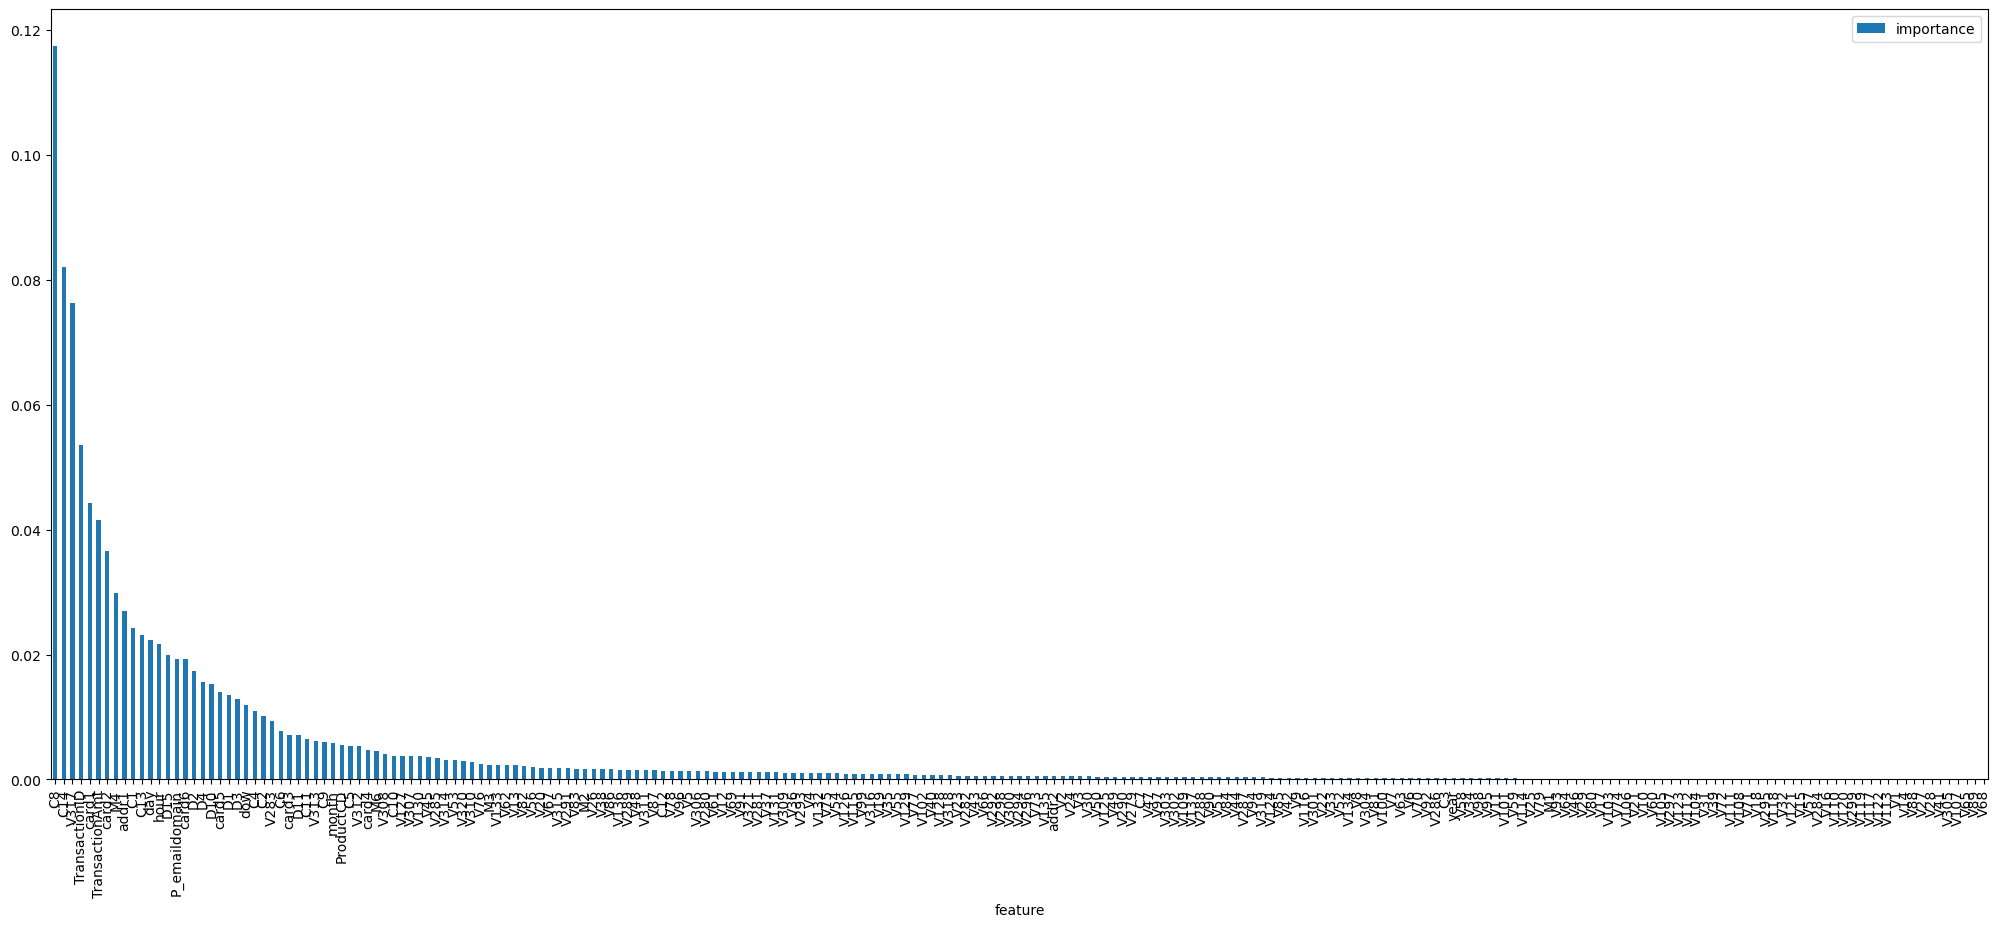

In [40]:
importances_df = pd.DataFrame({'feature': X.columns, 'importance': importances})

importances_df = importances_df.sort_values('importance', ascending=False).set_index('feature')

plt.rcParams['figure.figsize'] = (25, 10)
importances_df.plot.bar();

##  Selecionar as características: Vamos selecionar as características com as maiores importâncias.

In [24]:
#selecionar as características com as maiores importâncias
selected_features = X.columns[importances > 0.01]

#criação de um novo conjunto de dados apenas com as características selecionadas
X_selected = X[selected_features]

In [25]:
X_selected

,TransactionID,TransactionAmt,card1,card2,card5,card6,addr1,P_emaildomain,C1,C2,...,D2,D3,D4,D10,D15,M4,V317,hour,day,dow
0,2987000,68.500,10095,500,38,1,166,31,1.0,1.0,...,97.0,13.0,26.0,13.0,0.0,2,117.0,0,2,5
1,2987001,29.000,1372,303,2,1,173,16,1.0,1.0,...,97.0,8.0,0.0,0.0,0.0,0,0.0,0,2,5
2,2987002,59.000,2833,389,58,2,178,36,1.0,1.0,...,97.0,8.0,0.0,0.0,315.0,0,0.0,0,2,5
3,2987003,50.000,13341,466,14,2,282,54,2.0,5.0,...,112.0,0.0,94.0,84.0,111.0,0,1404.0,0,2,5
4,2987004,50.000,2712,413,2,1,241,16,1.0,1.0,...,97.0,8.0,26.0,15.0,52.0,3,0.0,0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166886,3153886,100.000,1135,220,108,1,183,19,1.0,1.0,...,97.0,8.0,26.0,15.0,52.0,3,0.0,3,11,3
101908,3088908,24.486,10350,399,106,1,332,16,2.0,2.0,...,97.0,8.0,0.0,0.0,0.0,2,0.0,17,24,6
415353,3402353,39.000,9864,484,108,2,298,2,3.0,13.0,...,4.0,1.0,66.0,54.0,66.0,1,705.0,12,1,6
547946,3534946,17.091,983,444,108,1,332,16,2.0,6.0,...,97.0,8.0,289.0,0.0,0.0,2,0.0,14,17,3


In [26]:
# Converter o array numpy de volta em um dataframe pandas
X_selected = pd.DataFrame(X_selected, columns=selected_features)

In [27]:
X_selected = X_selected.reset_index(drop=True)

In [28]:
X_selected

,TransactionID,TransactionAmt,card1,card2,card5,card6,addr1,P_emaildomain,C1,C2,...,D2,D3,D4,D10,D15,M4,V317,hour,day,dow
0,2987000,68.500,10095,500,38,1,166,31,1.0,1.0,...,97.0,13.0,26.0,13.0,0.0,2,117.0,0,2,5
1,2987001,29.000,1372,303,2,1,173,16,1.0,1.0,...,97.0,8.0,0.0,0.0,0.0,0,0.0,0,2,5
2,2987002,59.000,2833,389,58,2,178,36,1.0,1.0,...,97.0,8.0,0.0,0.0,315.0,0,0.0,0,2,5
3,2987003,50.000,13341,466,14,2,282,54,2.0,5.0,...,112.0,0.0,94.0,84.0,111.0,0,1404.0,0,2,5
4,2987004,50.000,2712,413,2,1,241,16,1.0,1.0,...,97.0,8.0,26.0,15.0,52.0,3,0.0,0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139749,3153886,100.000,1135,220,108,1,183,19,1.0,1.0,...,97.0,8.0,26.0,15.0,52.0,3,0.0,3,11,3
1139750,3088908,24.486,10350,399,106,1,332,16,2.0,2.0,...,97.0,8.0,0.0,0.0,0.0,2,0.0,17,24,6
1139751,3402353,39.000,9864,484,108,2,298,2,3.0,13.0,...,4.0,1.0,66.0,54.0,66.0,1,705.0,12,1,6
1139752,3534946,17.091,983,444,108,1,332,16,2.0,6.0,...,97.0,8.0,289.0,0.0,0.0,2,0.0,14,17,3


In [29]:
y.shape

(1139754,)

In [30]:
# Converter a série y em DataFrame
y_df = pd.DataFrame(y, columns=["isFraud"])

In [31]:
y_df

,isFraud
0,0
1,0
2,0
3,0
4,0
...,...
166886,1
101908,1
415353,1
547946,1


In [32]:
y_df = y_df.reset_index(drop=True)

In [33]:
y_df

,isFraud
0,0
1,0
2,0
3,0
4,0
...,...
1139749,1
1139750,1
1139751,1
1139752,1


## new data é o novo dataframe com os X(features) importantes selecionados e y ( a classe)

In [34]:
# Concatenar os DataFrames X_selected e y_df
new_data = pd.concat([X_selected, y_df], axis=1)

In [35]:
new_data

,TransactionID,TransactionAmt,card1,card2,card5,card6,addr1,P_emaildomain,C1,C2,...,D3,D4,D10,D15,M4,V317,hour,day,dow,isFraud
0,2987000,68.500,10095,500,38,1,166,31,1.0,1.0,...,13.0,26.0,13.0,0.0,2,117.0,0,2,5,0
1,2987001,29.000,1372,303,2,1,173,16,1.0,1.0,...,8.0,0.0,0.0,0.0,0,0.0,0,2,5,0
2,2987002,59.000,2833,389,58,2,178,36,1.0,1.0,...,8.0,0.0,0.0,315.0,0,0.0,0,2,5,0
3,2987003,50.000,13341,466,14,2,282,54,2.0,5.0,...,0.0,94.0,84.0,111.0,0,1404.0,0,2,5,0
4,2987004,50.000,2712,413,2,1,241,16,1.0,1.0,...,8.0,26.0,15.0,52.0,3,0.0,0,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139749,3153886,100.000,1135,220,108,1,183,19,1.0,1.0,...,8.0,26.0,15.0,52.0,3,0.0,3,11,3,1
1139750,3088908,24.486,10350,399,106,1,332,16,2.0,2.0,...,8.0,0.0,0.0,0.0,2,0.0,17,24,6,1
1139751,3402353,39.000,9864,484,108,2,298,2,3.0,13.0,...,1.0,66.0,54.0,66.0,1,705.0,12,1,6,1
1139752,3534946,17.091,983,444,108,1,332,16,2.0,6.0,...,8.0,289.0,0.0,0.0,2,0.0,14,17,3,1


## Treinar e avaliar o modelo:

## Aplicação dos modelos de ML dos trabalhos relacionados de classificação:
#### Seleção de modelos:
* Regressão Logística
* Árvore de Decisão
* KNeighborsClassifier
* SVM (retiramos pelo fato de demorar demais)
* Random Forest.
* XG Boost


#### Divisão dos dados

In [41]:
# Dividir os dados em features e labels
X = new_data.drop("isFraud", axis=1)
y = new_data["isFraud"]

# Dividir os dados em treinamento e teste usando o StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]

In [42]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(854815, 25) (284939, 25) (854815,) (284939,)


## PIPELINE REGRESSÃO LOGÍSTICA

Existem alguns parâmetros que você pode ajustar para uma regressão logística no scikit-learn. Aqui estão alguns exemplos:

* `penalty`: Especifica a norma a ser usada na regularização. Pode ser 'L1', 'L2', 'elasticnet' ou 'none'.


* `C`: Parâmetro de inversão de regularização. Valores menores especificam uma regularização mais forte.


* `solver`: Algoritmo a ser usado no problema de otimização. Pode ser 'newton-cg', 'lbfgs', 'liblinear', 'sag' ou 'saga'.


* `max_iter`: Número máximo de iterações para o solucionador convergir.

In [43]:
import time

start_time = time.time()


pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ('Logistic_Regression', LogisticRegression(max_iter=1000))
])

param_grid = [
    {'Logistic_Regression__solver': ['newton-cg', 'lbfgs', 'sag'],
     'Logistic_Regression__C': [0.1, 1.0, 10.0, 100.0],
     'Logistic_Regression__penalty': ['l1', 'l2']}
]

grid.best_score_ é um atributo do objeto GridSearchCV do Scikit-learn, que retorna a melhor pontuação média (score) obtida durante a pesquisa no grid de hiperparâmetros. A pontuação é calculada usando a métrica de avaliação definida no objeto GridSearchCV.

O valor retornado por grid.best_score_ é a média das pontuações de validação cruzada para o conjunto de treinamento, utilizando os hiperparâmetros que produziram a melhor pontuação média. É importante lembrar que esta pontuação é estimada usando apenas os dados de treinamento.

A função GridSearchCV da biblioteca sklearn.model_selection possui diversos parâmetros que podem ser utilizados para controlar o processo de busca de hiperparâmetros e a validação cruzada. Abaixo estão listados os principais parâmetros:

* `estimator`: representa o modelo a ser otimizado e deve ser uma instância de um estimador do scikit-learn.


* `param_grid`: um dicionário que mapeia nomes de parâmetros do modelo para listas de valores a serem explorados durante a busca de hiperparâmetros.


* `scoring`: uma métrica de avaliação que será utilizada para avaliar o desempenho do modelo. Deve ser uma string que representa o nome da métrica ou uma função que calcula a métrica. Por padrão, é utilizado o score da função score() do estimador.


* `cv`: número de partições a serem utilizadas na validação cruzada.


* `n_jobs`: número de trabalhos em paralelo a serem executados. Se n_jobs=-1, todos os processadores disponíveis serão utilizados.


* `verbose`: nível de verbosidade do output.


* `pre_dispatch`: número de trabalhos que devem ser despachados para o trabalhador antes que o próximo lote de tarefas seja despachado. O valor padrão é 2 * n_jobs.


* `return_train_score`: se True, inclui o score de treino para cada combinação de parâmetros no resultado. O valor padrão é False.


* `refit`: se True, refita o modelo com os melhores parâmetros encontrados usando todos os dados disponíveis. O valor padrão é True.


* `iid`: se True, assume que as dobras de validação cruzada são independentes e identicamente distribuídas (i.i.d.), o que não é garantido para todos os tipos de dados. O valor padrão é True.


* `error_score`: valor a ser atribuído ao score caso ocorra algum erro na validação cruzada.


* `return_estimator`: se True, retorna os estimadores que foram ajustados para cada combinação de parâmetros. O valor padrão é False.

In [44]:
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

#y_pred = grid.predict(X_train)

print("Melhores parâmetros: ", grid.best_params_)
print("Melhores hiper-parâmetros: ", grid.best_estimator_)
lr_mean_score = grid.best_score_
print("Melhor pontuação de validação cruzada: ", lr_mean_score)

execution_time = time.time() - start_time
minutes, seconds = divmod(execution_time, 60)

print("--- %d minutes %d seconds ---" % (minutes, seconds))

results = []
results.append(("Melhores parâmetros: ", grid.best_params_))
results.append(("Melhores hiper-parâmetros: ", grid.best_estimator_))
results.append(("Melhor pontuação de validação cruzada: ", lr_mean_score))

df = pd.DataFrame(results)

#df.to_csv("S_features_grid_search_RL.csv", index=False)

#df.to_html("S_features_grid_search_RL.html")

Melhores parâmetros:  {'Logistic_Regression__C': 10.0, 'Logistic_Regression__penalty': 'l2', 'Logistic_Regression__solver': 'sag'}
Melhores hiper-parâmetros:  Pipeline(steps=[('std_scaler', StandardScaler()),
                ('Logistic_Regression',
                 LogisticRegression(C=10.0, max_iter=1000, solver='sag'))])
Melhor pontuação de validação cruzada:  0.6941806121792435
--- 60 minutes 18 seconds ---


In [45]:
y_pred_lr = grid.predict(X_test)

# Printing the classification report
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.70      0.69      0.69    142470
           1       0.69      0.70      0.70    142469

    accuracy                           0.70    284939
   macro avg       0.70      0.70      0.70    284939
weighted avg       0.70      0.70      0.70    284939



## PIPELINE ÁRVORE DE DECISÃO

In [46]:
start_time = time.time()

pipe_TREE = Pipeline([
    ('std_scaler', StandardScaler()),
    ('Decision_Tree', DecisionTreeClassifier())
])

param_grid_TREE = [
    {'Decision_Tree__criterion': ['gini', 'entropy'],
     'Decision_Tree__max_depth': [1, 2, 4, 8, 16, 32, None]}
]

In [51]:
grid1 = GridSearchCV(pipe_TREE, param_grid_TREE, cv=5)
grid1.fit(X_train, y_train)

#y_pred = grid1.predict(X_train)

print("Melhores parâmetros: ", grid1.best_params_)
print("Melhores hiper-parâmetros: ", grid1.best_estimator_)
dtc_mean_score = grid1.best_score_
print("Melhor pontuação de validação cruzada: ", dtc_mean_score)

execution_time = time.time() - start_time
minutes, seconds = divmod(execution_time, 60)

print("--- %d minutes %d seconds ---" % (minutes, seconds))

results1 = []
results1.append(("Melhores parâmetros: ", grid1.best_params_))
results1.append(("Melhores hiper-parâmetros: ", grid1.best_estimator_))
results1.append(("Melhor pontuação de validação cruzada: ", dtc_mean_score))

df1 = pd.DataFrame(results1)

#df1.to_csv("S_features_grid_search_TREE.csv", index=False)

#df1.to_html("S_features_grid_search_TREE.html")

Melhores parâmetros:  {'Decision_Tree__criterion': 'gini', 'Decision_Tree__max_depth': None}
Melhores hiper-parâmetros:  Pipeline(steps=[('std_scaler', StandardScaler()),
                ('Decision_Tree', DecisionTreeClassifier())])
Melhor pontuação de validação cruzada:  0.9882629574820282
--- 12 minutes 2 seconds ---


In [52]:
# Predict the test set
y_pred_dtc = grid1.predict(X_test)

# Printing the classification report
print(classification_report(y_test, y_pred_dtc))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    142470
           1       0.98      1.00      0.99    142469

    accuracy                           0.99    284939
   macro avg       0.99      0.99      0.99    284939
weighted avg       0.99      0.99      0.99    284939



## PIPELINE KNN

In [53]:
start_time = time.time()

pipe_KNN = Pipeline([
    ('std_scaler', StandardScaler()),
    ('KNN', KNeighborsClassifier())
])

param_grid_KNN = [
    {'KNN__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
     'KNN__weights': ['uniform', 'distance']}
]

In [54]:
grid2 = GridSearchCV(pipe_KNN, param_grid_KNN, cv=5)
grid2.fit(X_train, y_train)

#y_pred = grid2.predict(X_train)

print("Melhores parâmetros: ", grid2.best_params_)
print("Melhores hiper-parâmetros: ", grid2.best_estimator_)
knn_mean_score = grid.best_score_
print("Melhor pontuação de validação cruzada: ", knn_mean_score)

execution_time = time.time() - start_time
minutes, seconds = divmod(execution_time, 60)

print("--- %d minutes %d seconds ---" % (minutes, seconds))

results2 = []
results2.append(("Melhores parâmetros: ", grid2.best_params_))
results2.append(("Melhores hiper-parâmetros: ", grid2.best_estimator_))
results2.append(("Melhor pontuação de validação cruzada: ", knn_mean_score))

df2 = pd.DataFrame(results2)

#df2.to_csv("S_features_grid_search_KNN.csv", index=False)

#df2.to_html("S_features_grid_search_KNN.html")

Melhores parâmetros:  {'KNN__n_neighbors': 1, 'KNN__weights': 'uniform'}
Melhores hiper-parâmetros:  Pipeline(steps=[('std_scaler', StandardScaler()),
                ('KNN', KNeighborsClassifier(n_neighbors=1))])
Melhor pontuação de validação cruzada:  0.6941806121792435
--- 2405 minutes 20 seconds ---


In [55]:
# Predict the test set
y_pred_knn = grid2.predict(X_test)

# Printing the classification report
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    142470
           1       0.98      1.00      0.99    142469

    accuracy                           0.99    284939
   macro avg       0.99      0.99      0.99    284939
weighted avg       0.99      0.99      0.99    284939



## PIPELINE RANDOM FOREST TREE

In [56]:
start_time = time.time()

pipe_RFOREST = Pipeline([
    ('std_scaler', StandardScaler()),
    ('Random_Forest', RandomForestClassifier())
])

param_grid_RFOREST = [
    {'Random_Forest__n_estimators': [10, 50, 100, 200, 500],
     'Random_Forest__criterion': ['gini', 'entropy'],
     'Random_Forest__max_depth': [1, 2, 4, 8, 16, 32, None]}
]

In [57]:
grid3 = GridSearchCV(pipe_RFOREST, param_grid_RFOREST, cv=5)
grid3.fit(X_train, y_train)

#y_pred = grid3.predict(X_train)

print("Melhores parâmetros: ", grid3.best_params_)
print("Melhores hiper-parâmetros: ", grid3.best_estimator_)
rf_mean_score = grid3.best_score_
print("Melhor pontuação de validação cruzada: ", rf_mean_score)

execution_time = time.time() - start_time
minutes, seconds = divmod(execution_time, 60)

print("--- %d minutes %d seconds ---" % (minutes, seconds))

results3 = []
results3.append(("Melhores parâmetros: ", grid3.best_params_))
results3.append(("Melhores hiper-parâmetros: ", grid3.best_estimator_))
results3.append(("Melhor pontuação de validação cruzada: ", rf_mean_score))

df3 = pd.DataFrame(results3)

#df3.to_csv("S_features_grid_search_RFOREST.csv", index=False)

#df3.to_html("S_features_grid_search_RFOREST.html")

Melhores parâmetros:  {'Random_Forest__criterion': 'entropy', 'Random_Forest__max_depth': None, 'Random_Forest__n_estimators': 200}
Melhores hiper-parâmetros:  Pipeline(steps=[('std_scaler', StandardScaler()),
                ('Random_Forest',
                 RandomForestClassifier(criterion='entropy',
                                        n_estimators=200))])
Melhor pontuação de validação cruzada:  0.6941806121792435
--- 715 minutes 44 seconds ---


In [58]:
# Predict the test set
y_pred_rf = grid3.predict(X_test)

# Printing the classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142470
           1       1.00      1.00      1.00    142469

    accuracy                           1.00    284939
   macro avg       1.00      1.00      1.00    284939
weighted avg       1.00      1.00      1.00    284939



## PIPELINE XG BOOST

In [59]:
import xgboost as xgb

In [60]:
start_time = time.time()

pipe_XGBOOST = Pipeline([
    ('std_scaler', StandardScaler()),
    ('XGBoost', xgb.XGBClassifier())
])

param_grid_XGBOOST = [
    {'XGBoost__n_estimators': [10, 50, 100, 200, 500],
     'XGBoost__max_depth': [1, 2, 4, 8, 16, 32, None],
     'XGBoost__learning_rate': [0.001, 0.01, 0.1, 1.0]}
]

In [61]:
grid4 = GridSearchCV(pipe_XGBOOST, param_grid_XGBOOST, cv=5)
grid4.fit(X_train, y_train)

#y_pred = grid4.predict(X_train)

print("Melhores parâmetros: ", grid4.best_params_)
print("Melhores hiper-parâmetros: ", grid4.best_estimator_)
xgb_mean_score = grid4.best_score_
print("Melhor pontuação de validação cruzada: ", xgb_mean_score)

execution_time = time.time() - start_time
minutes, seconds = divmod(execution_time, 60)

print("--- %d minutes %d seconds ---" % (minutes, seconds))

results4 = []
results4.append(("Melhores parâmetros: ", grid4.best_params_))
results4.append(("Melhores hiwwper-parâmetros: ", grid4.best_estimator_))
results4.append(("Melhor pontuação de validação cruzada: ", xgb_mean_score))

df4 = pd.DataFrame(results4)

#df4.to_csv("S_features_grid_search_XGBOOST.csv", index=False)

#df4.to_html("S_features_grid_search_XGBOOST.html")

[01:36:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:36:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:36:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:36:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[01:39:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:39:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:39:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:39:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[01:44:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:44:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:44:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:44:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[01:53:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:53:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:53:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:54:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:14:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:15:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:15:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:17:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[03:05:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:07:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:09:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:11:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[04:29:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:30:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:30:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:30:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[04:42:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:42:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:43:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[04:46:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:46:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:46:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:46:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[04:52:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:53:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:53:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:54:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[05:06:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:09:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:11:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:13:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[05:50:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:55:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:01:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:06:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[07:23:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:33:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:33:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[07:47:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:47:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:47:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:47:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[07:50:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:50:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:50:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:50:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[07:55:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:55:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:55:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:55:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[08:04:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:04:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:05:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:05:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[08:25:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:26:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:27:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:28:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[09:11:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:13:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:15:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:17:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:12:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:12:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:12:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:13:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:24:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:28:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:28:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:28:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:28:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:35:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:35:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:36:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:37:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:50:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:52:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:57:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[11:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:26:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:29:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:30:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:06:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:06:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:06:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:06:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [62]:
# Predict the test set
y_pred_xgb = grid4.predict(X_test)

# Printing the classification report
print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142470
           1       1.00      1.00      1.00    142469

    accuracy                           1.00    284939
   macro avg       1.00      1.00      1.00    284939
weighted avg       1.00      1.00      1.00    284939



## Resultados

In [63]:
from sklearn import metrics

A métrica roc_auc (Receiver Operating Characteristic - Area Under the Curve) é uma medida da capacidade de um modelo de classificação binária de distinguir entre duas classes. Especificamente, a área sob a curva ROC é calculada a partir do gráfico da curva ROC que plota a taxa de verdadeiros positivos (True Positive Rate - TPR) versus a taxa de falsos positivos (False Positive Rate - FPR) para diferentes valores de threshold (ponto de corte) usado para classificar as amostras como positivas ou negativas. A área sob a curva ROC é uma medida da qualidade geral do modelo, sendo que o valor máximo é 1, que indica um modelo perfeito. Um valor de 0,5 indica que o modelo não é melhor do que uma escolha aleatória. Em geral, quanto maior o valor da métrica, melhor o modelo é considerado em distinguir entre as duas classes.

In [64]:
lr_mean_score # média do score da regressão logística
precision = precision_score(y_train, grid.predict(X_train))
recall = recall_score(y_train, grid.predict(X_train))
f1 = f1_score(y_train, grid.predict(X_train))
ballance_accuracy = balanced_accuracy_score(y_train, grid.predict(X_train))
accuracy = accuracy_score(y_train, grid.predict(X_train))
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_train, grid.predict(X_train), average='macro')
roc_auc = roc_auc_score(y_train, grid.predict(X_train))
confusion_matrix = metrics.confusion_matrix(y_train, grid.predict(X_train))
classification = metrics.classification_report(y_train, grid.predict(X_train))
print()
print('============================== {} - AVALIAÇÃO - REGRESSãO LOGISTICA ==============================')
print()
print ("MEAN SCORE:" "\n", lr_mean_score)
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - REGRESSãO LOGISTICA ==============================

MEAN SCORE:
 0.6941806121792435

PRECISãO:
 0.6912051787325734

RECALL:
 0.7024997192378243

F1:
 0.6968066836853098

ACURÁRIA BALANCEADA:
 0.694329172779436

ACURÁCIA:
 0.6943291823376988

PRECISãO MACRO:
 0.694381081503967

RECALL MACRO:
 0.694329172779436

F1 MACRO:
 0.6943087709970844

ROC/AUC:
 0.6943291727794361

MATRIZ DE CONFUSÃO:
 [[293269 134138]
 [127154 300254]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       0.70      0.69      0.69    427407
           1       0.69      0.70      0.70    427408

    accuracy                           0.69    854815
   macro avg       0.69      0.69      0.69    854815
weighted avg       0.69      0.69      0.69    854815




In [65]:
dtc_mean_score # média do score 
precision = precision_score(y_train, grid1.predict(X_train))
recall = recall_score(y_train, grid1.predict(X_train))
f1 = f1_score(y_train, grid1.predict(X_train))
ballance_accuracy = balanced_accuracy_score(y_train, grid1.predict(X_train))
accuracy = accuracy_score(y_train, grid1.predict(X_train))
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_train, grid1.predict(X_train), average='macro')
roc_auc = roc_auc_score(y_train, grid1.predict(X_train))
confusion_matrix = metrics.confusion_matrix(y_train, grid1.predict(X_train))
classification = metrics.classification_report(y_train, grid1.predict(X_train))

print()
print('============================== {} - AVALIAÇÃO - ÁRVORE DE DECISÃO ==============================')
print()
print ("MEAN SCORE:" "\n", dtc_mean_score)
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - ÁRVORE DE DECISÃO ==============================

MEAN SCORE:
 0.9882629574820282

PRECISãO:
 1.0

RECALL:
 1.0

F1:
 1.0

ACURÁRIA BALANCEADA:
 1.0

ACURÁCIA:
 1.0

PRECISãO MACRO:
 1.0

RECALL MACRO:
 1.0

F1 MACRO:
 1.0

ROC/AUC:
 1.0

MATRIZ DE CONFUSÃO:
 [[427407      0]
 [     0 427408]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    427407
           1       1.00      1.00      1.00    427408

    accuracy                           1.00    854815
   macro avg       1.00      1.00      1.00    854815
weighted avg       1.00      1.00      1.00    854815




In [66]:
knn_mean_score # média do score 
precision = precision_score(y_train, grid2.predict(X_train))
recall = recall_score(y_train, grid2.predict(X_train))
f1 = f1_score(y_train, grid2.predict(X_train))
ballance_accuracy = balanced_accuracy_score(y_train, grid2.predict(X_train))
accuracy = accuracy_score(y_train, grid2.predict(X_train))
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_train, grid2.predict(X_train), average='macro')
roc_auc = roc_auc_score(y_train, grid2.predict(X_train))
confusion_matrix = metrics.confusion_matrix(y_train, grid2.predict(X_train))
classification = metrics.classification_report(y_train, grid2.predict(X_train))
print()
print('============================== {} - AVALIAÇÃO - KNN ==============================')
print()
print ("MEAN SCORE:" "\n", knn_mean_score)
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - KNN ==============================

MEAN SCORE:
 0.6941806121792435

PRECISãO:
 1.0

RECALL:
 1.0

F1:
 1.0

ACURÁRIA BALANCEADA:
 1.0

ACURÁCIA:
 1.0

PRECISãO MACRO:
 1.0

RECALL MACRO:
 1.0

F1 MACRO:
 1.0

ROC/AUC:
 1.0

MATRIZ DE CONFUSÃO:
 [[427407      0]
 [     0 427408]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    427407
           1       1.00      1.00      1.00    427408

    accuracy                           1.00    854815
   macro avg       1.00      1.00      1.00    854815
weighted avg       1.00      1.00      1.00    854815




In [67]:
rf_mean_score # média do score 
precision = precision_score(y_train, grid3.predict(X_train))
recall = recall_score(y_train, grid3.predict(X_train))
f1 = f1_score(y_train, grid3.predict(X_train))
ballance_accuracy = balanced_accuracy_score(y_train, grid3.predict(X_train))
accuracy = accuracy_score(y_train, grid3.predict(X_train))
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_train, grid3.predict(X_train), average='macro')
roc_auc = roc_auc_score(y_train, grid3.predict(X_train))
confusion_matrix = metrics.confusion_matrix(y_train, grid3.predict(X_train))
classification = metrics.classification_report(y_train, grid3.predict(X_train))
print()
print('============================== {} - AVALIAÇÃO - RANDOM FOREST TREE ==============================')
print()
print ("MEAN SCORE:" "\n", rf_mean_score)
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - RANDOM FOREST TREE ==============================

MEAN SCORE:
 0.6941806121792435

PRECISãO:
 1.0

RECALL:
 1.0

F1:
 1.0

ACURÁRIA BALANCEADA:
 1.0

ACURÁCIA:
 1.0

PRECISãO MACRO:
 1.0

RECALL MACRO:
 1.0

F1 MACRO:
 1.0

ROC/AUC:
 1.0

MATRIZ DE CONFUSÃO:
 [[427407      0]
 [     0 427408]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    427407
           1       1.00      1.00      1.00    427408

    accuracy                           1.00    854815
   macro avg       1.00      1.00      1.00    854815
weighted avg       1.00      1.00      1.00    854815




In [68]:
xgb_mean_score # média do score 
precision = precision_score(y_train, grid4.predict(X_train))
recall = recall_score(y_train, grid4.predict(X_train))
f1 = f1_score(y_train, grid4.predict(X_train))
ballance_accuracy = balanced_accuracy_score(y_train, grid4.predict(X_train))
accuracy = accuracy_score(y_train, grid4.predict(X_train))
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_train, grid4.predict(X_train), average='macro')
roc_auc = roc_auc_score(y_train, grid4.predict(X_train))
confusion_matrix = metrics.confusion_matrix(y_train, grid4.predict(X_train))
classification = metrics.classification_report(y_train, grid4.predict(X_train))
print()
print('============================== {} - AVALIAÇÃO - XG BOOST ==============================')
print()
print ("MEAN SCORE:" "\n", xgb_mean_score)
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - XG BOOST ==============================

MEAN SCORE:
 0.9980416815334312

PRECISãO:
 1.0

RECALL:
 1.0

F1:
 1.0

ACURÁRIA BALANCEADA:
 1.0

ACURÁCIA:
 1.0

PRECISãO MACRO:
 1.0

RECALL MACRO:
 1.0

F1 MACRO:
 1.0

ROC/AUC:
 1.0

MATRIZ DE CONFUSÃO:
 [[427407      0]
 [     0 427408]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    427407
           1       1.00      1.00      1.00    427408

    accuracy                           1.00    854815
   macro avg       1.00      1.00      1.00    854815
weighted avg       1.00      1.00      1.00    854815




# Validação

In [69]:
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
ballance_accuracy = balanced_accuracy_score(y_test, y_pred_lr)
accuracy = accuracy_score(y_test, y_pred_lr)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_lr, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_lr)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_lr)
classification = metrics.classification_report(y_test, y_pred_lr)
print()
print('============================== {} - AVALIAÇÃO - REGRESSãO LOGÍSTICA ==============================')
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - REGRESSãO LOGÍSTICA ==============================

PRECISãO:
 0.6924031863167696

RECALL:
 0.7046796145126308

F1:
 0.6984874627779479

ACURÁRIA BALANCEADA:
 0.6958156267270812

ACURÁCIA:
 0.6958155956187114

PRECISãO MACRO:
 0.6958771776779069

RECALL MACRO:
 0.6958156267270812

F1 MACRO:
 0.6957917070559027

ROC/AUC:
 0.6958156267270812

MATRIZ DE CONFUSÃO:
 [[ 97870  44600]
 [ 42074 100395]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       0.70      0.69      0.69    142470
           1       0.69      0.70      0.70    142469

    accuracy                           0.70    284939
   macro avg       0.70      0.70      0.70    284939
weighted avg       0.70      0.70      0.70    284939




In [70]:
precision = precision_score(y_test, y_pred_dtc)
recall = recall_score(y_test, y_pred_dtc)
f1 = f1_score(y_test, y_pred_dtc)
ballance_accuracy = balanced_accuracy_score(y_test, y_pred_dtc)
accuracy = accuracy_score(y_test, y_pred_dtc)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_dtc, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_dtc)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_dtc)
classification = metrics.classification_report(y_test, y_pred_dtc)
print()
print('============================== {} - AVALIAÇÃO - ARVORE DE DECISÃO ==============================')
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - ARVORE DE DECISÃO ==============================

PRECISãO:
 0.981380707023393

RECALL:
 1.0

F1:
 0.9906028695491951

ACURÁRIA BALANCEADA:
 0.9905137923773426

ACURÁCIA:
 0.990513759085278

PRECISãO MACRO:
 0.9906903535116964

RECALL MACRO:
 0.9905137923773426

F1 MACRO:
 0.9905129059849633

ROC/AUC:
 0.9905137923773426

MATRIZ DE CONFUSÃO:
 [[139767   2703]
 [     0 142469]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    142470
           1       0.98      1.00      0.99    142469

    accuracy                           0.99    284939
   macro avg       0.99      0.99      0.99    284939
weighted avg       0.99      0.99      0.99    284939




In [71]:
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)
ballance_accuracy = balanced_accuracy_score(y_test, y_pred_knn)
accuracy = accuracy_score(y_test, y_pred_knn)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_knn, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_knn)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_knn)
classification = metrics.classification_report(y_test, y_pred_knn)
print()
print('============================== {} - AVALIAÇÃO - KNN ==============================')
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - KNN ==============================

PRECISãO:
 0.9792356863014641

RECALL:
 1.0

F1:
 0.9895089231453088

ACURÁRIA BALANCEADA:
 0.9893977679511476

ACURÁCIA:
 0.9893977307423695

PRECISãO MACRO:
 0.9896178431507321

RECALL MACRO:
 0.9893977679511476

F1 MACRO:
 0.9893965396163478

ROC/AUC:
 0.9893977679511475

MATRIZ DE CONFUSÃO:
 [[139449   3021]
 [     0 142469]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    142470
           1       0.98      1.00      0.99    142469

    accuracy                           0.99    284939
   macro avg       0.99      0.99      0.99    284939
weighted avg       0.99      0.99      0.99    284939




In [72]:
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
ballance_accuracy = balanced_accuracy_score(y_test, y_pred_rf)
accuracy = accuracy_score(y_test, y_pred_rf)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_rf)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
classification = metrics.classification_report(y_test, y_pred_rf)
print()
print('============================== {} - AVALIAÇÃO - RANDOM FOREST ==============================')
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - RANDOM FOREST ==============================

PRECISãO:
 0.9977519434134043

RECALL:
 1.0

F1:
 0.9988747068453581

ACURÁRIA BALANCEADA:
 0.9988734470414824

ACURÁCIA:
 0.9988734430878188

PRECISãO MACRO:
 0.9988759717067022

RECALL MACRO:
 0.9988734470414824

F1 MACRO:
 0.9988734416669636

ROC/AUC:
 0.9988734470414824

MATRIZ DE CONFUSÃO:
 [[142149    321]
 [     0 142469]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    142470
           1       1.00      1.00      1.00    142469

    accuracy                           1.00    284939
   macro avg       1.00      1.00      1.00    284939
weighted avg       1.00      1.00      1.00    284939




In [73]:
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
ballance_accuracy = balanced_accuracy_score(y_test, y_pred_xgb)
accuracy = accuracy_score(y_test, y_pred_xgb)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_xgb, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_xgb)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_xgb)
classification = metrics.classification_report(y_test, y_pred_xgb)
print()
print('============================== {} - AVALIAÇÃO - XGB BOOST ==============================')
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - XGB BOOST ==============================

PRECISãO:
 0.9969699514352494

RECALL:
 1.0

F1:
 0.9984826769363391

ACURÁRIA BALANCEADA:
 0.9984803818347723

ACURÁCIA:
 0.9984803765016372

PRECISãO MACRO:
 0.9984849757176246

RECALL MACRO:
 0.9984803818347723

F1 MACRO:
 0.9984803730086202

ROC/AUC:
 0.9984803818347722

MATRIZ DE CONFUSÃO:
 [[142037    433]
 [     0 142469]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    142470
           1       1.00      1.00      1.00    142469

    accuracy                           1.00    284939
   macro avg       1.00      1.00      1.00    284939
weighted avg       1.00      1.00      1.00    284939


